In [1]:
import pandas as pd
import random
from time import sleep
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import numpy as np
import nltk
import os
from sklearn import datasets
import pickle
from nltk.tokenize import word_tokenize
from sklearn.decomposition import NMF, TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.neighbors import NearestNeighbors
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc, fbeta_score
from sklearn.model_selection import learning_curve, KFold, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.preprocessing import normalize
import re
from unidecode import unidecode

import matplotlib.style as style
%matplotlib inline
plt.style.use('ggplot')

/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
with open('data/cleaned_df.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [3]:
df.head()

,song_owner,song_title,song_element,verse,artist
0,Childish Gambino,This Is America,[Bridge: Childish Gambino & Young Thug],"We just wanna party, Party just for you, We ju...",Childish Gambino
1,Childish Gambino,This Is America,[Chorus: Childish Gambino],"This is America, Don't catch you slippin' now,...",Childish Gambino
2,Childish Gambino,This Is America,"[Verse 1: Childish Gambino, Blocboy JB, Slim J...","This is America (skrrt, skrrt, woo), Don't cat...",Childish Gambino
3,Childish Gambino,This Is America,[Refrain: Choir & Childish Gambino],"Ooh-ooh-ooh-ooh-ooh, tell somebody, You go tel...",Childish Gambino
4,Childish Gambino,This Is America,"[Chorus: Childish Gambino, Slim Jxmmi & Young ...","This is America (woo, ayy), Don't catch you sl...",Childish Gambino


In [4]:
model_df = df.copy()

model_df = model_df[model_df['artist'] == 'Chance the Rapper']

In [5]:
model_df['verse_words'] = model_df['verse'].copy()
model_df['verse_words'] = model_df['verse_words'].str.lower()
model_df['verse_words'] = model_df['verse_words'].apply(lambda x: x.replace(',',''))
model_df['verse_words'] = model_df['verse_words'].apply(lambda x: x.split(' '))

In [6]:
model_df.head()

,song_owner,song_title,song_element,verse,artist,verse_words
316,Childish Gambino,They Don't Like Me,[Verse 1: Chance The Rapper],"Eddy Scissorhands is workin' on my linin', Get...",Chance the Rapper,"[eddy, scissorhands, is, workin', on, my, lini..."
793,Childish Gambino,The Worst Guys (Live at Governor’s Ball),[Verse 2: Chance The Rapper],"You are the prototype, I love you like you lov...",Chance the Rapper,"[you, are, the, prototype, i, love, you, like,..."
824,Chance The Rapper,Favorite Song,[Verse 1: Chance The Rapper],"Chance, acid rapper, soccer, hacky sacker, Coc...",Chance the Rapper,"[chance, acid, rapper, soccer, hacky, sacker, ..."
825,Chance The Rapper,Favorite Song,[Chorus: Chance The Rapper],"This shit my favorite song, you just don't kno...",Chance the Rapper,"[this, shit, my, favorite, song, you, just, do..."
826,Chance The Rapper,Favorite Song,[Verse 2: Chance The Rapper],Young Rascal Flatts - young ass kid ass could ...,Chance the Rapper,"[young, rascal, flatts, -, young, ass, kid, as..."


In [7]:
from nltk.tokenize import word_tokenize
model_df['tokenize_verse'] = model_df['verse'].copy()
model_df['tokenize_verse'] = model_df['tokenize_verse'].str.lower()
model_df['tokenize_verse'] = model_df['tokenize_verse'].apply(lambda x: word_tokenize(x))

In [8]:
model_df['verse'] = model_df['verse'].str.lower()
model_df['verse'] = model_df['verse'].apply(lambda x: x.replace("'",''))
model_df['verse'] = model_df['verse'].apply(lambda x: "".join([c if c.isalnum() else " " for c in x ]))
model_df['verse'] = model_df['verse'].apply(lambda x: x.replace('  ',' '))

In [9]:
stopwords = ["yeah", "uh", "huh", "aw", "oh", "la", "ayy",
            "na", "ha", "ay", "skrrt",
            "em", "bla", "woo", "wu", "ya", "wala", "woop", "wrarrr", "ooh",
            "ba", "duh", "du", "1", "2", "3", "4" ,"5" ,"6", "7", "8", "9", "0"]

for index, row in model_df.iterrows():
    querywords = row['verse'].split()

    resultwords  = [word for word in querywords if word.lower() not in stopwords]
    row['verse'] = ' '.join(resultwords)

model_df.verse[:5]

316    eddy scissorhands is workin on my linin gettin...
793    you are the prototype i love you like you love...
824    chance acid rapper soccer hacky sacker cocky k...
825    this shit my favorite song you just dont know ...
826    young rascal flatts young ass kid ass could ra...
Name: verse, dtype: object

In [10]:
verses = list(model_df.verse.values)

In [11]:
verses[:10]

['eddy scissorhands is workin on my linin gettin spiffy for these bitches i be eyeing fredward mercury was playin while im ridin down the ryan in a scion and im flyin but its cool i got insurance on the run because i got warrants but its cool i got endurance in school i got suspended but in turn i got some earnings couldve spent it all on thursday but i saved it for my parents but i spent a bit on friday in the night i hang with donald im tired of mcdonalds want a chick that cook chicano that cant speak a lick of english and pronounce my name like chano she say something something spanish i look back like bitch i know tonight imma make decisions for life take some lucys boomers dark liq and light some might drive thats that shit right there that i dont like there that shit just had to say shouts to the niggas that passed away and shots for the niggas thats here right now and shots at the niggas that got away so sad to say but its all good niggas gon celebrate and wait for the day and w

In [12]:
all_verses_all_rappers = ','.join(verses)

all_verses_all_rappers[:100]

'eddy scissorhands is workin on my linin gettin spiffy for these bitches i be eyeing fredward mercury'

In [13]:
file = all_verses_all_rappers

In [14]:
# Read in text and change unicode characters to ASCII
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file_len = len(file)
print(f'file_len = {file_len}')

file_len = 186806


In [15]:
chunk_len = 400

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

nt be im getting artsy fartsy house full of some hebru brantleys you must ve missed the come up i must be all i can be call me mister mufasa i had to master stampedes,i made it through made it through made it through and everything i gave to you i gave to you i gave to you you got it you got it you got it its coming coming coming coming so are you ready are you ready,are you ready for your blessing


In [16]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        output = self.encoder(input.view(1, -1))
        output, hidden = self.gru(output.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.randn(self.n_layers, 1, self.hidden_size))

In [17]:
def char2tensor(string):
    tensor = torch.zeros(len(string)).long()
    for char in range(len(string)):
        if string[char] in all_characters:
            tensor[char] = all_characters.index(string[char])
        else:
            tensor[char] = 94 #predict space if character unknown
        
    return Variable(tensor)

# Let's see it in action.
print(char2tensor('Metis0123abczABC'))

tensor([48, 14, 29, 18, 28,  0,  1,  2,  3, 10, 11, 12, 35, 36, 37, 38])


In [18]:
def random_training_set():
    chunk = random_chunk()
    inp = char2tensor(chunk[:-1])
    target = char2tensor(chunk[1:])
    return inp, target

In [19]:
def evaluate(model, prime_str='A', predict_len=100, temperature=0.8):
    
    hidden = model.init_hidden()
    prime_input = char2tensor(prime_str)
    predicted = prime_str
    
    # use priming string to build up hidden state
    
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = model(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char2tensor(predicted_char)
        
    return predicted

In [20]:
# helper function
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

In [21]:
# The actual training part
def train(inp, target):
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0

    for char in range(chunk_len):
        output, hidden = model(inp[char], hidden)
        loss += criterion(output, target[char].unsqueeze(0))

    loss.backward()
    model_optimizer.step()

    return loss.data.item() / chunk_len

In [22]:
# parameters
n_epochs = 1000
print_every = 100
plot_every = 10
hidden_size = 256
n_layers = 2
learning_rate = 0.001

# model declaration
model = RNN(n_characters, hidden_size, n_characters, n_layers)
model_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(model, 'A ', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 12s (100 10%) 2.2498]
A huthe kromy nots mons no th you sh i munt slou ond the hoas thorgato the mar the no a plis mim oll t 

 27s (200 20%) 2.0760]
A mnike i lint thees so minne up in veak s.in i giing yom bite for i a jusce i betk thace you mith i y 

 43s (300 30%) 1.7567]
A now in a i caus mupleis m stoum is in aid you god id herey the for a but bup whers my pave whing i g 

 9s (400 40%) 1.8638]
A stall your spights wondais ulleveed i llave thike thats there have cul a love you loke day whore a l 

 33s (500 50%) 1.7541]
A bere cown warties the pack the was im you rapper with you im im buckin the shoigh in jukee dant my d 

 43s (600 60%) 1.6438]
A i may in i rib shit to be slike or gott i she lope the folk it it you cell my girth little a let tro 

 0s (700 70%) 1.4189]
A know i got just mofying shoke dont bitch is up off her out pent preffour monhing toiler that its my  

 14s (800 80%) 1.8162]
A its anothing fuck a got here the much i fuck you and anotha lammoke fuck yo styol

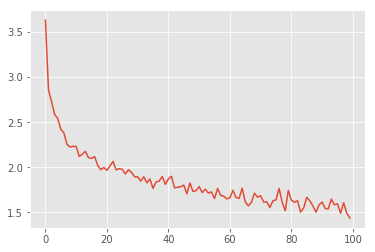

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [30]:
with open('models/chance_rnn_generator.pkl', 'wb') as picklefile:
    pickle.dump(model, picklefile)

In [24]:
# Evaluate model from this notebook
print(evaluate(model, 'To be or not to be: ', predict_len=200, temperature=0.5))

To be or not to be: to more the ready home we dont do the see daddy the dont the dont so so its ready and the same and the do the dont do the sunderse to the same dont do the orden me friend in the same do the same drugs


In [25]:
# Evaluate model from this notebook
print(evaluate(model, 'I miss you girl come back ', predict_len=200, temperature=0.5))

I miss you girl come back of the ready say a some and the day day i can she dont dont need a scell drugs we dont no me a call ready it so miss all with a dont we dont dont do the more again i miss my man and the ware i need a 


In [26]:
# Evaluate model from this notebook
print(evaluate(model, "Started from the bottom", predict_len=200, temperature=0.4))

Started from the bottome you still and to the same that say in the fucked probably fuck you same dont do the past i dont do the dang what the same that say the got the gotta say in the for to be more to the same a miss do t


In [27]:
# Evaluate model from this notebook
print(evaluate(model, "I'm the realest rapper alive", predict_len=200, temperature=0.4))

I'm the realest rapper alive was to the same ready to the same and talk with me to the we do the day same a dont do the praise hit to the ring we dont do the same dont do the same the rest same we dont way she dont down the same


In [28]:
# Evaluate model from this notebook
print(evaluate(model, "Smoke a lot of weed", predict_len=200, temperature=0.4))

Smoke a lot of weed and do the day in the round i dont do the dont wanna dont do the sade a way i dont no for a we dont do the same drugs do the same and was a christ no better the same a care to me and here fall i dont


In [29]:
# Evaluate model from this notebook
print(evaluate(model, "Baby come", predict_len=200, temperature=0.4))

Baby come i more whats no dont do the dont do the say the peal out my more my famo to the mire a came to the know the same and the said you same and the same to the blunt the same the got here fuck the past we
